Definitely failed:
- processing Sentinel 2 images manually (download is too cumbersome and geospatial data processing has many hurdles, like CRSs, rasterization, etc.)
- nDOM (no noticeable performance improvement and introduces unnecessary complexity)
- PALSAR raster
- using multiple metrics simultaneously -> too many edge cases and arbitrary decisions
- similarity matrix (as it is just high level and very unreadable for all bands and indices)

Hurdles:
- Limits of Google Earth Engine (Kontingente und Systemlimits)
- Slowness of computations, especially near the end, when everything had to work together
- keep oneself organized when having to manage everything within one project

Still interesting
- base area prediction (not feasible because of rapidly changing base area between 2017-2024 for study area)

# Similarity Matrix and Dendrogram

In [1]:
# List the optimal bands
from ltm.models import bands_from_importance

sentinel_bands, indices = bands_from_importance("../reports/band_importance.csv")

Initializing Earth Engine API...


In [2]:
from ltm.features import (
    get_similarity_matrix,
    load_raster,
    show_similarity_matrix,
)
from ltm.data import split_band_name

data = load_raster("../data/processed/band_importance/data.tif")

bands = sentinel_bands + indices
columns = [column for column in data.columns if split_band_name(column)[1] in bands]

<Axes: >

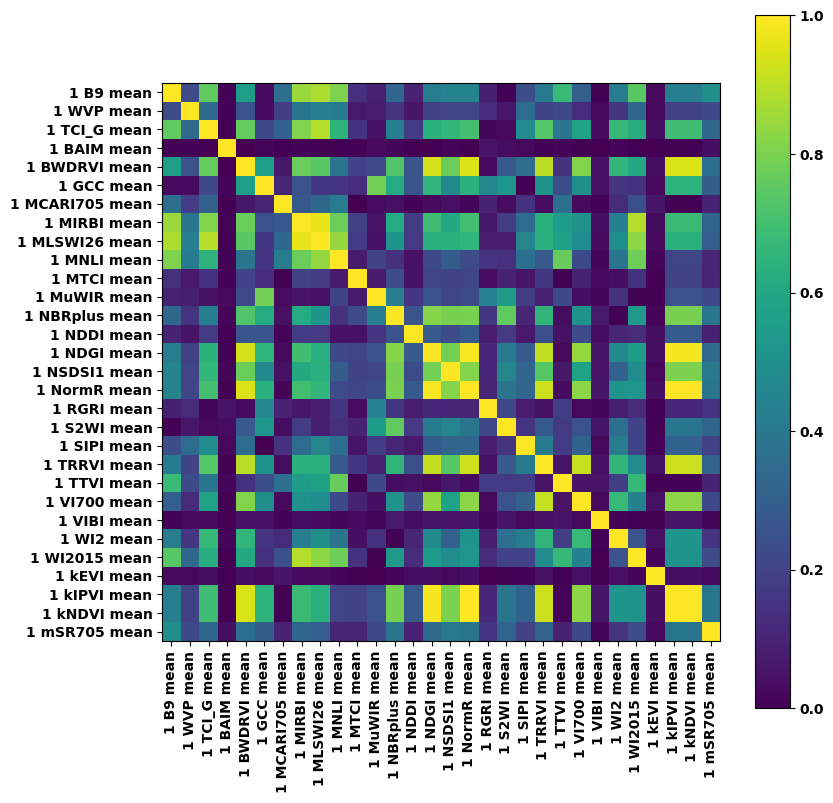

In [3]:
similarity_matrix = get_similarity_matrix(data[columns], method="pearson")
show_similarity_matrix(similarity_matrix)

<Axes: >

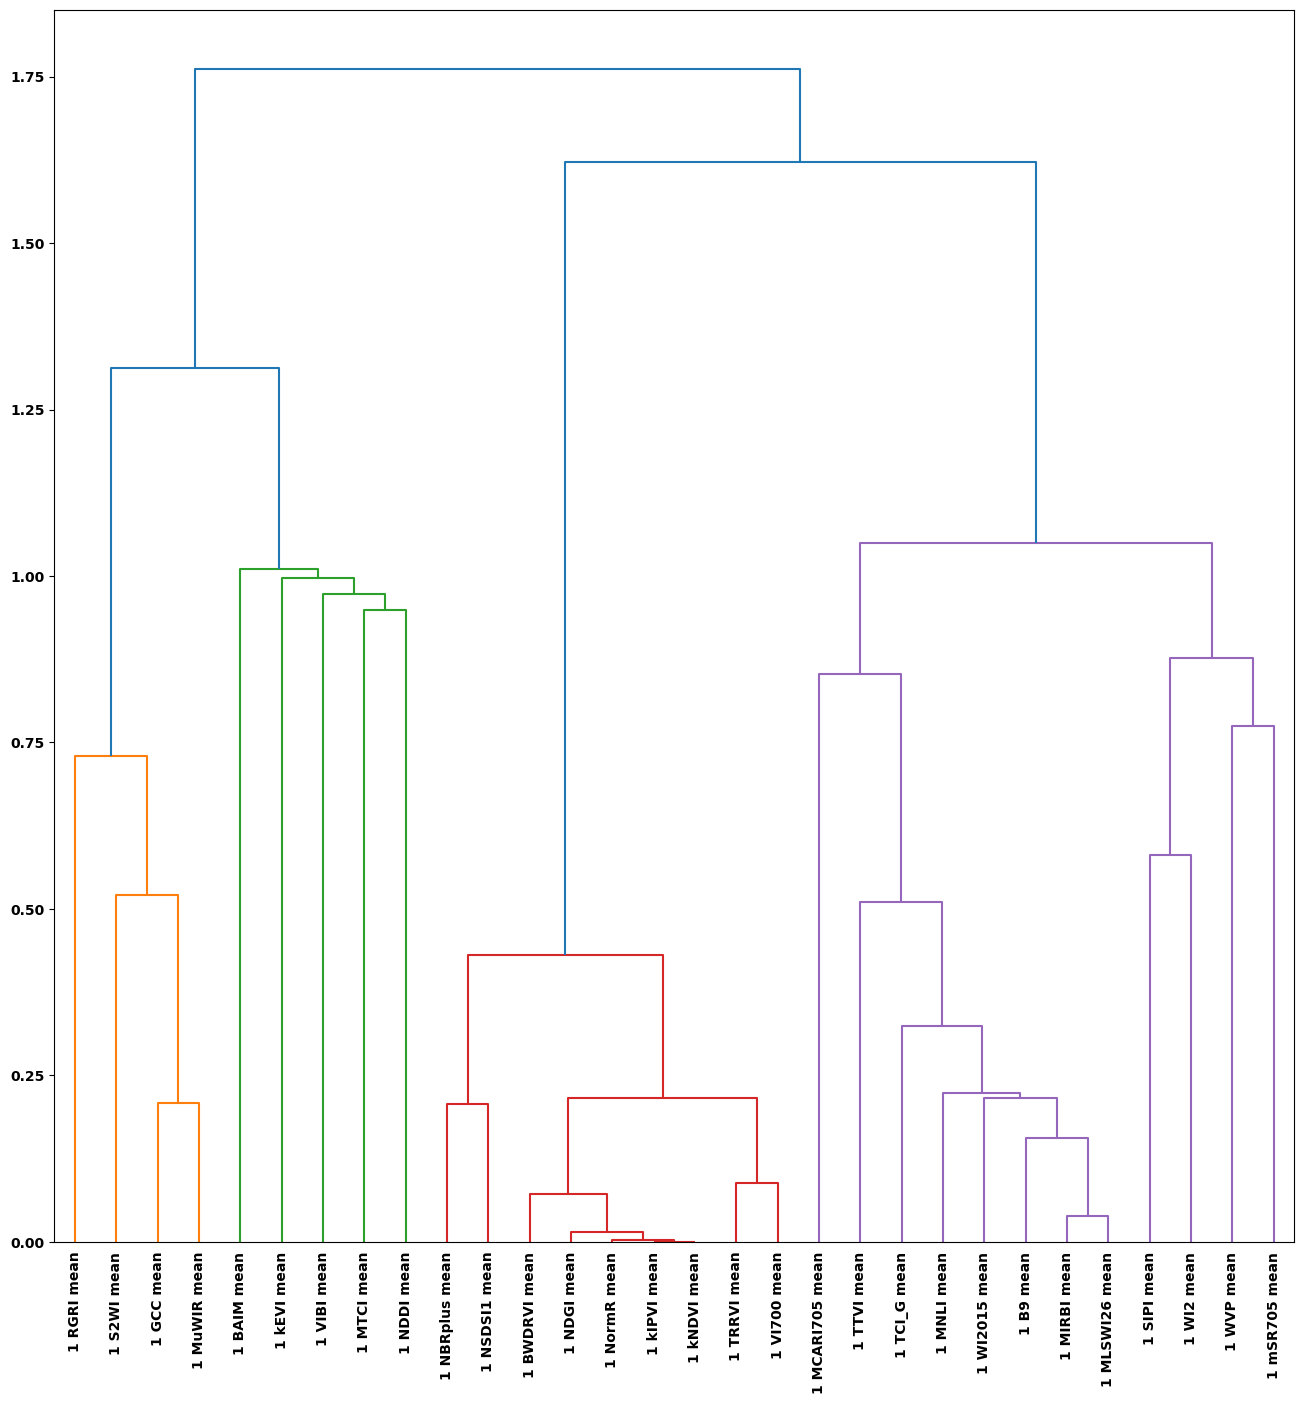

In [4]:
from ltm.features import show_dendrogram

show_dendrogram(similarity_matrix)

# Show timeseries

Preparing Sentinel-2 data...
Computing data...
GeoTIFF saved as ../data/processed/fails/timeseries.tif


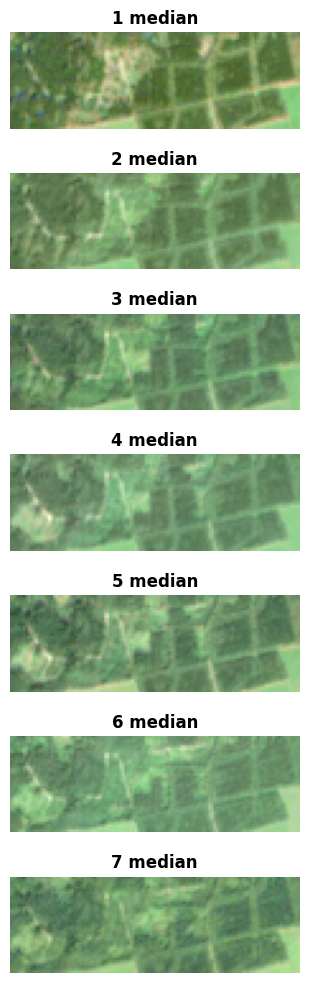

In [5]:
from ltm.data import sentinel_composite
from ltm.features import interpolate_data, load_raster, save_raster
from ltm.visualize import show_timeseries
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

data_path = "../data/processed/fails/timeseries.tif"
interpolated_path = "../data/processed/fails/timeseries_interpolated.tif"
target_path = "../data/processed/target.tif"
from_year = 2017
to_year = 2024

reducer = "median"
rgb_bands = ["TCI_R", "TCI_G", "TCI_B"]

if not Path(data_path).exists():
    Path(data_path).parent.mkdir(parents=True, exist_ok=True)

    sentinel_composite(
        target_path_from=target_path,
        data_path_to=data_path,
        time_window=(datetime(from_year, 4, 1), datetime(to_year, 4, 1)),
        num_composites=to_year - from_year,
        temporal_reducers=[reducer],
        sentinel_bands=rgb_bands,
    )

data = load_raster(data_path)
data = interpolate_data(data)
save_raster(data, data_path, interpolated_path)

show_timeseries(interpolated_path, reducer, rgb_bands)

plt.show()